In [2]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import os
import deepchem as dc
import numpy as np
from deepchem.molnet import load_qm9
import os
import logging
import deepchem
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger(__name__)

DEFAULT_DIR = './'
#GDB9_URL = 'featurization/sdf_files/dimers.sdf'
#QM9_CSV_URL = 'featurization/columb_matrix_input/dimers.sdf.csv'


def load_dimers(featurizer='CoulombMatrix',
             split='random',
             reload=True,
             move_mean=True,
             data_dir=None,
             save_dir=None,
             **kwargs):
  """Load dimer datasets."""
  # Featurize dimer dataset
  logger.info("About to featurize dimer dataset.")
  #dimer_tasks = [
  #    "induction","electrostatics","dispersion","total","exchange"
  #]

  dimer_tasks = [
      "induction"
  ]

  if data_dir is None:
    data_dir = DEFAULT_DIR
  if save_dir is None:
    save_dir = DEFAULT_DIR

  if reload:
    save_folder = os.path.join(save_dir, "dimer-featurized")
    if not move_mean:
      save_folder = os.path.join(save_folder, str(featurizer) + "_mean_unmoved")
    else:
      save_folder = os.path.join(save_folder, str(featurizer))

    if featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      save_folder = os.path.join(save_folder, img_spec)
    save_folder = os.path.join(save_folder, str(split))

    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_folder)
    if loaded:
      return dimer_tasks, all_dataset, transformers

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    dataset_file = os.path.join("featurization/columb_matrix_input/dimers.sdf")

    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=GDB9_URL, dest_dir=data_dir)
      deepchem.utils.untargz_file(
          os.path.join(data_dir, 'gdb9.tar.gz'), data_dir)
  else:
    dataset_file = os.path.join(data_dir, "dimer.sdf.csv")
    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=QM9_CSV_URL, dest_dir=data_dir)

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    if featurizer == 'CoulombMatrix':
      featurizer = deepchem.feat.CoulombMatrix(6)
    elif featurizer == 'BPSymmetryFunctionInput':
      featurizer = deepchem.feat.BPSymmetryFunctionInput(29)
    elif featurizer == 'Raw':
      featurizer = deepchem.feat.RawFeaturizer()
    elif featurizer == 'MP':
      featurizer = deepchem.feat.WeaveFeaturizer(
          graph_distance=False, explicit_H=True)
    loader = deepchem.data.SDFLoader(
        tasks=dimer_tasks,
        smiles_field="smiles",
        mol_field="mol",
        featurizer=featurizer)
  else:
    if featurizer == 'ECFP':
      featurizer = deepchem.feat.CircularFingerprint(size=1024)
    elif featurizer == 'GraphConv':
      featurizer = deepchem.feat.ConvMolFeaturizer()
    elif featurizer == 'Weave':
      featurizer = deepchem.feat.WeaveFeaturizer()
    elif featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      img_size = kwargs.get("img_size", 80)
      featurizer = deepchem.feat.SmilesToImage(
          img_size=img_size, img_spec=img_spec)
    loader = deepchem.data.CSVLoader(
        tasks=dimer_tasks, smiles_field="smiles", featurizer=featurizer)

  dataset = loader.featurize(dataset_file)
  if split == None:
    raise ValueError()
  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'stratified': deepchem.splits.SingletaskStratifiedSplitter(task_number=11)
  }
  splitter = splitters[split]
  frac_train = kwargs.get("frac_train", 0.8)
  frac_valid = kwargs.get('frac_valid', 0.1)
  frac_test = kwargs.get('frac_test', 0.1)

  train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
      dataset,
      frac_train=frac_train,
      frac_valid=frac_valid,
      frac_test=frac_test)
  transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=train_dataset, move_mean=move_mean)
  ]
  for transformer in transformers:
    train_dataset = transformer.transform(train_dataset)
    valid_dataset = transformer.transform(valid_dataset)
    test_dataset = transformer.transform(test_dataset)

  if reload:
    deepchem.utils.save.save_dataset_to_disk(
        save_folder, train_dataset, valid_dataset, test_dataset, transformers)
  return dimer_tasks, (train_dataset, valid_dataset, test_dataset), transformers

dimer_tasks, datasets, transformers = load_dimers()

train_dataset_i, valid_dataset_i, test_dataset_i = datasets
fit_transformers = [dc.trans.CoulombFitTransformer(train_dataset_i)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

batch_size = 30
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

model_i = dc.models.DTNNModel(
    len(dimer_tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    mode="regression")


# Fit trained model
model_i.fit(train_dataset_i, nb_epoch=200)

train_scores = model_i.evaluate(train_dataset_i, regression_metric, transformers)
print("Train scores [kcal/mol]")
print(train_scores)

valid_scores = model_i.evaluate(valid_dataset_i, regression_metric, transformers)
print("Valid scores [kcal/mol]")
print(valid_scores)

test_scores = model_i.evaluate(test_dataset_i, regression_metric, transformers)
print("Test scores [kcal/mol]")
print(test_scores)

y_pred_i = model_i.predict(test_dataset_i)

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.0385404720246498]
computed_metrics: [0.9972905142458571]
Train scores [kcal/mol]
{'mean_absolute_error': 0.0385404720246498, 'pearson_r2_score': 0.9972905142458571}
computed_metrics: [0.05823646009084396]
computed_metrics: [0.9917000992656727]
Valid scores [kcal/mol]
{'mean_absolute_error': 0.05823646009084396, 'pearson_r2_score': 0.9917000992656727}
computed_metrics: [0.053114940450592]
computed_metrics: [0.9901640139572627]
Test scores [kcal/mol]
{'mean_absolute_error': 0.053114940450592, 'pearson_r2_score': 0.9901640139572627}


In [3]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import os
import deepchem as dc
import numpy as np
from deepchem.molnet import load_qm9
import os
import logging
import deepchem
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger(__name__)

DEFAULT_DIR = './'
#GDB9_URL = 'featurization/sdf_files/dimers.sdf'
#QM9_CSV_URL = 'featurization/columb_matrix_input/dimers.sdf.csv'


def load_dimers(featurizer='CoulombMatrix',
             split='random',
             reload=True,
             move_mean=True,
             data_dir=None,
             save_dir=None,
             **kwargs):
  """Load dimer datasets."""
  # Featurize dimer dataset
  logger.info("About to featurize dimer dataset.")
  #dimer_tasks = [
  #    "induction","electrostatics","dispersion","total","exchange"
  #]

  dimer_tasks = [
      "dispersion"
  ]

  if data_dir is None:
    data_dir = DEFAULT_DIR
  if save_dir is None:
    save_dir = DEFAULT_DIR

  if reload:
    save_folder = os.path.join(save_dir, "dimer-featurized")
    if not move_mean:
      save_folder = os.path.join(save_folder, str(featurizer) + "_mean_unmoved")
    else:
      save_folder = os.path.join(save_folder, str(featurizer))

    if featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      save_folder = os.path.join(save_folder, img_spec)
    save_folder = os.path.join(save_folder, str(split))

    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_folder)
    if loaded:
      return dimer_tasks, all_dataset, transformers

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    dataset_file = os.path.join("featurization/columb_matrix_input/dimers.sdf")

    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=GDB9_URL, dest_dir=data_dir)
      deepchem.utils.untargz_file(
          os.path.join(data_dir, 'gdb9.tar.gz'), data_dir)
  else:
    dataset_file = os.path.join(data_dir, "dimer.sdf.csv")
    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=QM9_CSV_URL, dest_dir=data_dir)

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    if featurizer == 'CoulombMatrix':
      featurizer = deepchem.feat.CoulombMatrix(6)
    elif featurizer == 'BPSymmetryFunctionInput':
      featurizer = deepchem.feat.BPSymmetryFunctionInput(29)
    elif featurizer == 'Raw':
      featurizer = deepchem.feat.RawFeaturizer()
    elif featurizer == 'MP':
      featurizer = deepchem.feat.WeaveFeaturizer(
          graph_distance=False, explicit_H=True)
    loader = deepchem.data.SDFLoader(
        tasks=dimer_tasks,
        smiles_field="smiles",
        mol_field="mol",
        featurizer=featurizer)
  else:
    if featurizer == 'ECFP':
      featurizer = deepchem.feat.CircularFingerprint(size=1024)
    elif featurizer == 'GraphConv':
      featurizer = deepchem.feat.ConvMolFeaturizer()
    elif featurizer == 'Weave':
      featurizer = deepchem.feat.WeaveFeaturizer()
    elif featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      img_size = kwargs.get("img_size", 80)
      featurizer = deepchem.feat.SmilesToImage(
          img_size=img_size, img_spec=img_spec)
    loader = deepchem.data.CSVLoader(
        tasks=dimer_tasks, smiles_field="smiles", featurizer=featurizer)

  dataset = loader.featurize(dataset_file)
  if split == None:
    raise ValueError()
  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'stratified': deepchem.splits.SingletaskStratifiedSplitter(task_number=11)
  }
  splitter = splitters[split]
  frac_train = kwargs.get("frac_train", 0.8)
  frac_valid = kwargs.get('frac_valid', 0.1)
  frac_test = kwargs.get('frac_test', 0.1)

  train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
      dataset,
      frac_train=frac_train,
      frac_valid=frac_valid,
      frac_test=frac_test)
  transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=train_dataset, move_mean=move_mean)
  ]
  for transformer in transformers:
    train_dataset = transformer.transform(train_dataset)
    valid_dataset = transformer.transform(valid_dataset)
    test_dataset = transformer.transform(test_dataset)

  if reload:
    deepchem.utils.save.save_dataset_to_disk(
        save_folder, train_dataset, valid_dataset, test_dataset, transformers)
  return dimer_tasks, (train_dataset, valid_dataset, test_dataset), transformers

dimer_tasks, datasets, transformers = load_dimers()

train_dataset_d, valid_dataset_d, test_dataset_d = datasets
fit_transformers = [dc.trans.CoulombFitTransformer(train_dataset_d)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

batch_size = 30
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

model_d = dc.models.DTNNModel(
    len(dimer_tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    mode="regression")


# Fit trained model
model_d.fit(train_dataset_d, nb_epoch=200)

train_scores = model_d.evaluate(train_dataset_d, regression_metric, transformers)
print("Train scores [kcal/mol]")
print(train_scores)

valid_scores = model_d.evaluate(valid_dataset_d, regression_metric, transformers)
print("Valid scores [kcal/mol]")
print(valid_scores)

test_scores = model_d.evaluate(test_dataset_d, regression_metric, transformers)
print("Test scores [kcal/mol]")
print(test_scores)

y_pred_d = model_d.predict(test_dataset_d)

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.039555294945428164]
computed_metrics: [0.9961421514925228]
Train scores [kcal/mol]
{'mean_absolute_error': 0.039555294945428164, 'pearson_r2_score': 0.9961421514925228}
computed_metrics: [0.0605073074064664]
computed_metrics: [0.9875119955692817]
Valid scores [kcal/mol]
{'mean_absolute_error': 0.0605073074064664, 'pearson_r2_score': 0.9875119955692817}
computed_metrics: [0.05111337602297799]
computed_metrics: [0.9913726090471483]
Test scores [kcal/mol]
{'mean_absolute_error': 0.05111337602297799, 'pearson_r2_score': 0.9913726090471483}


In [4]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import os
import deepchem as dc
import numpy as np
from deepchem.molnet import load_qm9
import os
import logging
import deepchem
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger(__name__)

DEFAULT_DIR = './'
#GDB9_URL = 'featurization/sdf_files/dimers.sdf'
#QM9_CSV_URL = 'featurization/columb_matrix_input/dimers.sdf.csv'


def load_dimers(featurizer='CoulombMatrix',
             split='random',
             reload=True,
             move_mean=True,
             data_dir=None,
             save_dir=None,
             **kwargs):
  """Load dimer datasets."""
  # Featurize dimer dataset
  logger.info("About to featurize dimer dataset.")
  #dimer_tasks = [
  #    "induction","electrostatics","dispersion","total","exchange"
  #]

  dimer_tasks = [
      "electrostatics"
  ]

  if data_dir is None:
    data_dir = DEFAULT_DIR
  if save_dir is None:
    save_dir = DEFAULT_DIR

  if reload:
    save_folder = os.path.join(save_dir, "dimer-featurized")
    if not move_mean:
      save_folder = os.path.join(save_folder, str(featurizer) + "_mean_unmoved")
    else:
      save_folder = os.path.join(save_folder, str(featurizer))

    if featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      save_folder = os.path.join(save_folder, img_spec)
    save_folder = os.path.join(save_folder, str(split))

    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_folder)
    if loaded:
      return dimer_tasks, all_dataset, transformers

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    dataset_file = os.path.join("featurization/columb_matrix_input/dimers.sdf")

    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=GDB9_URL, dest_dir=data_dir)
      deepchem.utils.untargz_file(
          os.path.join(data_dir, 'gdb9.tar.gz'), data_dir)
  else:
    dataset_file = os.path.join(data_dir, "dimer.sdf.csv")
    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=QM9_CSV_URL, dest_dir=data_dir)

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    if featurizer == 'CoulombMatrix':
      featurizer = deepchem.feat.CoulombMatrix(6)
    elif featurizer == 'BPSymmetryFunctionInput':
      featurizer = deepchem.feat.BPSymmetryFunctionInput(29)
    elif featurizer == 'Raw':
      featurizer = deepchem.feat.RawFeaturizer()
    elif featurizer == 'MP':
      featurizer = deepchem.feat.WeaveFeaturizer(
          graph_distance=False, explicit_H=True)
    loader = deepchem.data.SDFLoader(
        tasks=dimer_tasks,
        smiles_field="smiles",
        mol_field="mol",
        featurizer=featurizer)
  else:
    if featurizer == 'ECFP':
      featurizer = deepchem.feat.CircularFingerprint(size=1024)
    elif featurizer == 'GraphConv':
      featurizer = deepchem.feat.ConvMolFeaturizer()
    elif featurizer == 'Weave':
      featurizer = deepchem.feat.WeaveFeaturizer()
    elif featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      img_size = kwargs.get("img_size", 80)
      featurizer = deepchem.feat.SmilesToImage(
          img_size=img_size, img_spec=img_spec)
    loader = deepchem.data.CSVLoader(
        tasks=dimer_tasks, smiles_field="smiles", featurizer=featurizer)

  dataset = loader.featurize(dataset_file)
  if split == None:
    raise ValueError()
  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'stratified': deepchem.splits.SingletaskStratifiedSplitter(task_number=11)
  }
  splitter = splitters[split]
  frac_train = kwargs.get("frac_train", 0.8)
  frac_valid = kwargs.get('frac_valid', 0.1)
  frac_test = kwargs.get('frac_test', 0.1)

  train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
      dataset,
      frac_train=frac_train,
      frac_valid=frac_valid,
      frac_test=frac_test)
  transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=train_dataset, move_mean=move_mean)
  ]
  for transformer in transformers:
    train_dataset = transformer.transform(train_dataset)
    valid_dataset = transformer.transform(valid_dataset)
    test_dataset = transformer.transform(test_dataset)

  if reload:
    deepchem.utils.save.save_dataset_to_disk(
        save_folder, train_dataset, valid_dataset, test_dataset, transformers)
  return dimer_tasks, (train_dataset, valid_dataset, test_dataset), transformers

dimer_tasks, datasets, transformers = load_dimers()

train_dataset_el, valid_dataset_el, test_dataset_el = datasets
fit_transformers = [dc.trans.CoulombFitTransformer(train_dataset_el)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

batch_size = 30
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

model_el = dc.models.DTNNModel(
    len(dimer_tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    mode="regression")


# Fit trained model
model_el.fit(train_dataset_el, nb_epoch=200)

train_scores = model_el.evaluate(train_dataset_el, regression_metric, transformers)
print("Train scores [kcal/mol]")
print(train_scores)

valid_scores = model_el.evaluate(valid_dataset_el, regression_metric, transformers)
print("Valid scores [kcal/mol]")
print(valid_scores)

test_scores = model_el.evaluate(test_dataset_el, regression_metric, transformers)
print("Test scores [kcal/mol]")
print(test_scores)

y_pred_el = model_el.predict(test_dataset_el)

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.03553531468091789]
computed_metrics: [0.9962470666753638]
Train scores [kcal/mol]
{'mean_absolute_error': 0.03553531468091789, 'pearson_r2_score': 0.9962470666753638}
computed_metrics: [0.058159047071763115]
computed_metrics: [0.980313186159941]
Valid scores [kcal/mol]
{'mean_absolute_error': 0.058159047071763115, 'pearson_r2_score': 0.980313186159941}
computed_metrics: [0.0480476184240783]
computed_metrics: [0.988711196370644]
Test scores [kcal/mol]
{'mean_absolute_error': 0.0480476184240783, 'pearson_r2_score': 0.988711196370644}


In [5]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import os
import deepchem as dc
import numpy as np
from deepchem.molnet import load_qm9
import os
import logging
import deepchem
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger(__name__)

DEFAULT_DIR = './'
#GDB9_URL = 'featurization/sdf_files/dimers.sdf'
#QM9_CSV_URL = 'featurization/columb_matrix_input/dimers.sdf.csv'


def load_dimers(featurizer='CoulombMatrix',
             split='random',
             reload=True,
             move_mean=True,
             data_dir=None,
             save_dir=None,
             **kwargs):
  """Load dimer datasets."""
  # Featurize dimer dataset
  logger.info("About to featurize dimer dataset.")
  #dimer_tasks = [
  #    "induction","electrostatics","dispersion","total","exchange"
  #]

  dimer_tasks = [
      "exchange"
  ]

  if data_dir is None:
    data_dir = DEFAULT_DIR
  if save_dir is None:
    save_dir = DEFAULT_DIR

  if reload:
    save_folder = os.path.join(save_dir, "dimer-featurized")
    if not move_mean:
      save_folder = os.path.join(save_folder, str(featurizer) + "_mean_unmoved")
    else:
      save_folder = os.path.join(save_folder, str(featurizer))

    if featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      save_folder = os.path.join(save_folder, img_spec)
    save_folder = os.path.join(save_folder, str(split))

    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_folder)
    if loaded:
      return dimer_tasks, all_dataset, transformers

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    dataset_file = os.path.join("featurization/columb_matrix_input/dimers.sdf")

    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=GDB9_URL, dest_dir=data_dir)
      deepchem.utils.untargz_file(
          os.path.join(data_dir, 'gdb9.tar.gz'), data_dir)
  else:
    dataset_file = os.path.join(data_dir, "dimer.sdf.csv")
    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=QM9_CSV_URL, dest_dir=data_dir)

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    if featurizer == 'CoulombMatrix':
      featurizer = deepchem.feat.CoulombMatrix(6)
    elif featurizer == 'BPSymmetryFunctionInput':
      featurizer = deepchem.feat.BPSymmetryFunctionInput(29)
    elif featurizer == 'Raw':
      featurizer = deepchem.feat.RawFeaturizer()
    elif featurizer == 'MP':
      featurizer = deepchem.feat.WeaveFeaturizer(
          graph_distance=False, explicit_H=True)
    loader = deepchem.data.SDFLoader(
        tasks=dimer_tasks,
        smiles_field="smiles",
        mol_field="mol",
        featurizer=featurizer)
  else:
    if featurizer == 'ECFP':
      featurizer = deepchem.feat.CircularFingerprint(size=1024)
    elif featurizer == 'GraphConv':
      featurizer = deepchem.feat.ConvMolFeaturizer()
    elif featurizer == 'Weave':
      featurizer = deepchem.feat.WeaveFeaturizer()
    elif featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      img_size = kwargs.get("img_size", 80)
      featurizer = deepchem.feat.SmilesToImage(
          img_size=img_size, img_spec=img_spec)
    loader = deepchem.data.CSVLoader(
        tasks=dimer_tasks, smiles_field="smiles", featurizer=featurizer)

  dataset = loader.featurize(dataset_file)
  if split == None:
    raise ValueError()
  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'stratified': deepchem.splits.SingletaskStratifiedSplitter(task_number=11)
  }
  splitter = splitters[split]
  frac_train = kwargs.get("frac_train", 0.8)
  frac_valid = kwargs.get('frac_valid', 0.1)
  frac_test = kwargs.get('frac_test', 0.1)

  train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
      dataset,
      frac_train=frac_train,
      frac_valid=frac_valid,
      frac_test=frac_test)
  transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=train_dataset, move_mean=move_mean)
  ]
  for transformer in transformers:
    train_dataset = transformer.transform(train_dataset)
    valid_dataset = transformer.transform(valid_dataset)
    test_dataset = transformer.transform(test_dataset)

  if reload:
    deepchem.utils.save.save_dataset_to_disk(
        save_folder, train_dataset, valid_dataset, test_dataset, transformers)
  return dimer_tasks, (train_dataset, valid_dataset, test_dataset), transformers

dimer_tasks, datasets, transformers = load_dimers()

train_dataset_ex, valid_dataset_ex, test_dataset_ex = datasets
fit_transformers = [dc.trans.CoulombFitTransformer(train_dataset_ex)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

batch_size = 30
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

model_ex = dc.models.DTNNModel(
    len(dimer_tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    mode="regression")


# Fit trained model
model_ex.fit(train_dataset_ex, nb_epoch=200)

train_scores = model_ex.evaluate(train_dataset_ex, regression_metric, transformers)
print("Train scores [kcal/mol]")
print(train_scores)

valid_scores = model_ex.evaluate(valid_dataset_ex, regression_metric, transformers)
print("Valid scores [kcal/mol]")
print(valid_scores)

test_scores = model_ex.evaluate(test_dataset_ex, regression_metric, transformers)
print("Test scores [kcal/mol]")
print(test_scores)

y_pred_ex = model_ex.predict(test_dataset_ex)

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.052793419614926305]
computed_metrics: [0.9975599723082734]
Train scores [kcal/mol]
{'mean_absolute_error': 0.052793419614926305, 'pearson_r2_score': 0.9975599723082734}
computed_metrics: [0.07954370818350218]
computed_metrics: [0.984151552098624]
Valid scores [kcal/mol]
{'mean_absolute_error': 0.07954370818350218, 'pearson_r2_score': 0.984151552098624}
computed_metrics: [0.06853039990279951]
computed_metrics: [0.9855757883399608]
Test scores [kcal/mol]
{'mean_absolute_error': 0.06853039990279951, 'pearson_r2_score': 0.9855757883399608}


In [6]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import os
import deepchem as dc
import numpy as np
from deepchem.molnet import load_qm9
import os
import logging
import deepchem
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger(__name__)

DEFAULT_DIR = './'
#GDB9_URL = 'featurization/sdf_files/dimers.sdf'
#QM9_CSV_URL = 'featurization/columb_matrix_input/dimers.sdf.csv'


def load_dimers(featurizer='CoulombMatrix',
             split='random',
             reload=True,
             move_mean=True,
             data_dir=None,
             save_dir=None,
             **kwargs):
  """Load dimer datasets."""
  # Featurize dimer dataset
  logger.info("About to featurize dimer dataset.")
  #dimer_tasks = [
  #    "induction","electrostatics","dispersion","total","exchange"
  #]

  dimer_tasks = [
      "total"
  ]

  if data_dir is None:
    data_dir = DEFAULT_DIR
  if save_dir is None:
    save_dir = DEFAULT_DIR

  if reload:
    save_folder = os.path.join(save_dir, "dimer-featurized")
    if not move_mean:
      save_folder = os.path.join(save_folder, str(featurizer) + "_mean_unmoved")
    else:
      save_folder = os.path.join(save_folder, str(featurizer))

    if featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      save_folder = os.path.join(save_folder, img_spec)
    save_folder = os.path.join(save_folder, str(split))

    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_folder)
    if loaded:
      return dimer_tasks, all_dataset, transformers

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    dataset_file = os.path.join("featurization/columb_matrix_input/dimers.sdf")

    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=GDB9_URL, dest_dir=data_dir)
      deepchem.utils.untargz_file(
          os.path.join(data_dir, 'gdb9.tar.gz'), data_dir)
  else:
    dataset_file = os.path.join(data_dir, "dimer.sdf.csv")
    if not os.path.exists(dataset_file):
      deepchem.utils.download_url(url=QM9_CSV_URL, dest_dir=data_dir)

  if featurizer in ['CoulombMatrix', 'BPSymmetryFunctionInput', 'MP', 'Raw']:
    if featurizer == 'CoulombMatrix':
      featurizer = deepchem.feat.CoulombMatrix(6)
    elif featurizer == 'BPSymmetryFunctionInput':
      featurizer = deepchem.feat.BPSymmetryFunctionInput(29)
    elif featurizer == 'Raw':
      featurizer = deepchem.feat.RawFeaturizer()
    elif featurizer == 'MP':
      featurizer = deepchem.feat.WeaveFeaturizer(
          graph_distance=False, explicit_H=True)
    loader = deepchem.data.SDFLoader(
        tasks=dimer_tasks,
        smiles_field="smiles",
        mol_field="mol",
        featurizer=featurizer)
  else:
    if featurizer == 'ECFP':
      featurizer = deepchem.feat.CircularFingerprint(size=1024)
    elif featurizer == 'GraphConv':
      featurizer = deepchem.feat.ConvMolFeaturizer()
    elif featurizer == 'Weave':
      featurizer = deepchem.feat.WeaveFeaturizer()
    elif featurizer == "smiles2img":
      img_spec = kwargs.get("img_spec", "std")
      img_size = kwargs.get("img_size", 80)
      featurizer = deepchem.feat.SmilesToImage(
          img_size=img_size, img_spec=img_spec)
    loader = deepchem.data.CSVLoader(
        tasks=dimer_tasks, smiles_field="smiles", featurizer=featurizer)

  dataset = loader.featurize(dataset_file)
  if split == None:
    raise ValueError()
  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'stratified': deepchem.splits.SingletaskStratifiedSplitter(task_number=11)
  }
  splitter = splitters[split]
  frac_train = kwargs.get("frac_train", 0.8)
  frac_valid = kwargs.get('frac_valid', 0.1)
  frac_test = kwargs.get('frac_test', 0.1)

  train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
      dataset,
      frac_train=frac_train,
      frac_valid=frac_valid,
      frac_test=frac_test)
  transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=train_dataset, move_mean=move_mean)
  ]
  for transformer in transformers:
    train_dataset = transformer.transform(train_dataset)
    valid_dataset = transformer.transform(valid_dataset)
    test_dataset = transformer.transform(test_dataset)

  if reload:
    deepchem.utils.save.save_dataset_to_disk(
        save_folder, train_dataset, valid_dataset, test_dataset, transformers)
  return dimer_tasks, (train_dataset, valid_dataset, test_dataset), transformers

dimer_tasks, datasets, transformers = load_dimers()

train_dataset_tot, valid_dataset_tot, test_dataset_tot = datasets
fit_transformers = [dc.trans.CoulombFitTransformer(train_dataset_tot)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

batch_size = 30
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

model_tot = dc.models.DTNNModel(
    len(dimer_tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    mode="regression")


# Fit trained model
model_tot.fit(train_dataset_tot, nb_epoch=200)

train_scores = model_tot.evaluate(train_dataset_tot, regression_metric, transformers)
print("Train scores [kcal/mol]")
print(train_scores)

valid_scores = model_tot.evaluate(valid_dataset_tot, regression_metric, transformers)
print("Valid scores [kcal/mol]")
print(valid_scores)

test_scores = model_tot.evaluate(test_dataset_tot, regression_metric, transformers)
print("Test scores [kcal/mol]")
print(test_scores)

y_pred_tot = model_tot.predict(test_dataset_tot)

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.05322010817150948]
computed_metrics: [0.994181098004614]
Train scores [kcal/mol]
{'mean_absolute_error': 0.05322010817150948, 'pearson_r2_score': 0.994181098004614}
computed_metrics: [0.07878346413287421]
computed_metrics: [0.9818968390210534]
Valid scores [kcal/mol]
{'mean_absolute_error': 0.07878346413287421, 'pearson_r2_score': 0.9818968390210534}
computed_metrics: [0.06084230192484112]
computed_metrics: [0.9878631718456413]
Test scores [kcal/mol]
{'mean_absolute_error': 0.06084230192484112, 'pearson_r2_score': 0.9878631718456413}


In [ ]:
test = model.evaluate(test_dataset_tot, regression_metric, transformers)

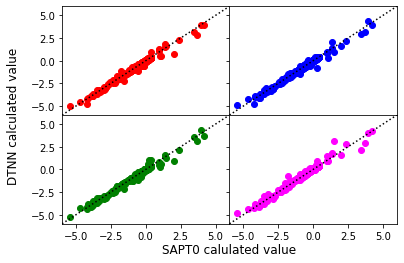

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2,2,figsize=(6,4),gridspec_kw={'wspace': 0,'hspace':0},sharey=True,sharex=True)
ax[0,0].plot([-6,6],[-6,6],':k')
ax[0,0].scatter(test_dataset_i.y,y_pred_i,color='red')
ax[0,0].yaxis.set_label_coords(-0.25,0)
ax[0,0].set_xlim(-6,6)
ax[0,0].set_ylim(-6,6)
ax[0,0].set_ylabel('DTNN calculated value',fontsize=12)
ax[0,0].set_yticks((-5,-2.5,0,2.5,5))

ax[0,1].plot([-6,6],[-6,6],':k')
ax[0,1].scatter(test_dataset_d.y,y_pred_d,color='blue')
ax[0,1].set_xlim(-6,6)
ax[0,1].set_ylim(-6,6)

ax[1,0].plot([-6,6],[-6,6],':k')
ax[1,0].scatter(test_dataset_el.y,y_pred_el,color='green')
ax[1,0].set_xlim(-6,6)
ax[1,0].set_ylim(-6,6)
ax[1,0].xaxis.set_label_coords(1.0,-0.175)
ax[1,0].set_xlabel('SAPT0 calulated value',fontsize=12)
ax[1,0].set_xticks((-5,-2.5,0,2.5,5))


ax[1,1].plot([-6,6],[-6,6],':k')
ax[1,1].scatter(test_dataset_ex.y,y_pred_ex,color='magenta')
ax[1,1].set_xlim(-6,6)
ax[1,1].set_ylim(-6,6)
ax[1,1].set_xticks((-5,-2.5,0,2.5,5))

plt.show()

fig.savefig('4_correlation_predict.svg',dpi=600)

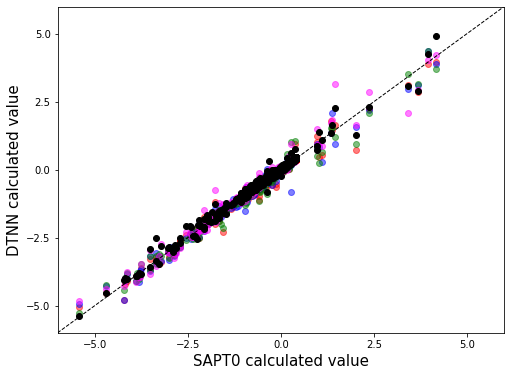

In [8]:
fig, ax = plt.subplots(figsize=(8,6),gridspec_kw={'wspace': 0,'hspace':0},sharey=True,sharex=True)
#ax.plot([-6,6],[-6,6],':k')

#ax.plot([-6,6],[-6 + diff_std,6 + diff_std],'g',lw=1)
#ax.plot([-6,6],[-6 - diff_std,6 - diff_std],'g',lw=1)

#ax.plot([-6,6],[-6 ,6],'--k',lw=1)
ax.plot([-6,6],[-6 ,6],'--k',lw=1)

ax.scatter(test_dataset_i.y,y_pred_i,color='red',alpha=0.5)
ax.scatter(test_dataset_d.y,y_pred_d,color='blue',alpha=0.5)
ax.scatter(test_dataset_el.y,y_pred_el,color='green',alpha=0.5)
ax.scatter(test_dataset_ex.y,y_pred_ex,color='magenta',alpha=0.5)
ax.scatter(test_dataset_tot.y,y_pred_tot,color='black',alpha=1)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_ylabel('DTNN calculated value',fontsize=15)
ax.set_xlabel('SAPT0 calculated value',fontsize=15)
ax.set_yticks((-5,-2.5,0,2.5,5))
ax.set_xticks((-5,-2.5,0,2.5,5))

fig.savefig('total_correlation_predict.svg',dpi=600)

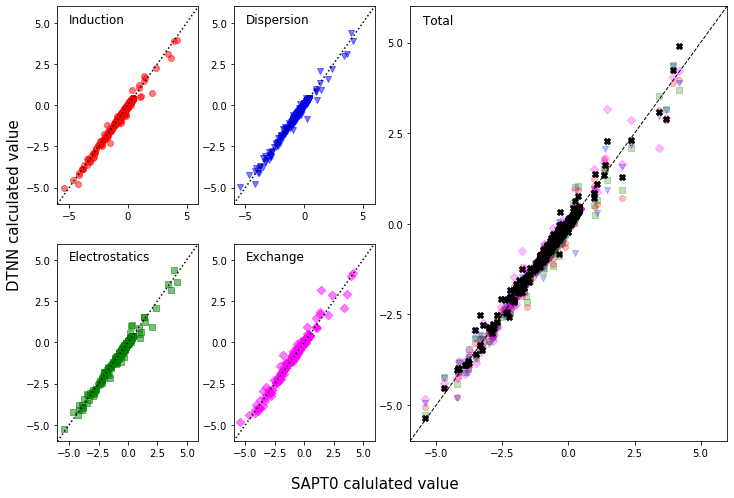

In [9]:
gridsize = (2, 4)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (1, 0))
ax4 = plt.subplot2grid(gridsize, (1, 1))
ax5 = plt.subplot2grid(gridsize, (0, 2), colspan=2, rowspan=2)


ax1.plot([-6,6],[-6,6],':k')
ax1.scatter(test_dataset_i.y,y_pred_i,color='red',alpha=0.5,marker='o')
ax1.yaxis.set_label_coords(-0.25,0)
ax1.set_xlim(-6,6)
ax1.set_ylim(-6,6)
ax1.set_ylabel('DTNN calculated value',fontsize=15)
ax1.set_yticks((-5,-2.5,0,2.5,5))
ax1.text(-5,5,'Induction',fontsize=12)

ax2.plot([-6,6],[-6,6],':k')
ax2.scatter(test_dataset_d.y,y_pred_d,color='blue',alpha=0.5,marker='v')
ax2.set_xlim(-6,6)
ax2.set_ylim(-6,6)
ax2.set_yticks((-5,-2.5,0,2.5,5))
ax2.text(-5,5,'Dispersion',fontsize=12)

ax3.plot([-6,6],[-6,6],':k')
ax3.scatter(test_dataset_el.y,y_pred_el,color='green',alpha=0.5,marker='s')
ax3.set_xlim(-6,6)
ax3.set_ylim(-6,6)
ax3.xaxis.set_label_coords(2.25,-0.175)
ax3.set_xlabel('SAPT0 calulated value',fontsize=15)
ax3.set_xticks((-5,-2.5,0,2.5,5))
ax3.set_yticks((-5,-2.5,0,2.5,5))
ax3.text(-5,5,'Electrostatics',fontsize=12)

ax4.plot([-6,6],[-6,6],':k')
ax4.scatter(test_dataset_ex.y,y_pred_ex,color='magenta',alpha=0.5,marker='D')
ax4.set_xlim(-6,6)
ax4.set_ylim(-6,6)
ax4.set_xticks((-5,-2.5,0,2.5,5))
ax4.set_yticks((-5,-2.5,0,2.5,5))
ax4.text(-5,5,'Exchange',fontsize=12)

ax5.plot([-6,6],[-6 ,6],'--k',lw=1)
ax5.scatter(test_dataset_i.y,y_pred_i,color='red',alpha=0.25,marker='o')
ax5.scatter(test_dataset_d.y,y_pred_d,color='blue',alpha=0.25,marker='v')
ax5.scatter(test_dataset_el.y,y_pred_el,color='green',alpha=0.25,marker='s')
ax5.scatter(test_dataset_ex.y,y_pred_ex,color='magenta',alpha=0.25,marker='D')
ax5.scatter(test_dataset_tot.y,y_pred_tot,color='black',alpha=1,marker='X')
ax5.set_xlim(-6,6)
ax5.set_ylim(-6,6)
ax5.set_yticks((-5,-2.5,0,2.5,5))
ax5.set_xticks((-5,-2.5,0,2.5,5))
ax5.text(-5.5,5.5,'Total',fontsize=12)

fig.subplots_adjust(wspace=0.25)
fig.savefig('combined_accuracy_prediction_plot.jpg',dpi=600)

In [91]:
list_of_diffs = []
for x,y in zip(test_dataset_i.y,y_pred_i):
    list_of_diffs.append(x-y)
diff_mean = np.mean(list_of_diffs)
diff_std  = np.std(list_of_diffs)

z = 3.291

con_int = z * (diff_std/(np.sqrt(1000)))
int_tot = con_int + diff_mean

In [38]:
import numpy.random

#params_dict = {"learning_rate": np.power(10., np.random.uniform(-5, -3, size=1)),
#               "decay": np.power(10, np.random.uniform(-6, -4, size=1)),
#              "nb_epoch": [20] }
#n_features = train_dataset.get_data_shape()[0]


#def model_builder(model_params, model_dir):    
#    model = dc.models.TensorflowMultiTaskRegressor(
#    1, n_features, layer_sizes=[1000], dropouts=[.25],
#    batch_size=50, **model_params)
#    return model

batch_size = 30
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

metric = dc.metrics.Metric(dc.metrics.r2_score)

params_dict = {"learning_rate": np.power(10., np.random.uniform(-5, -3, size=1)),
               "decay": np.power(10, np.random.uniform(-6, -4, size=1)),
               "nb_epoch": [20] }
n_features = train_dataset_i.get_data_shape()[0]

def model_builder(model_params, model_dir):
    model = dc.models.DTNNModel(
    len(dimer_tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    use_queue=False,
    mode="regression")
    return model

optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_dnn_hyperparams, all_dnn_results = optimizer.hyperparam_search(
    params_dict, train_dataset_i, valid_dataset_i, transformers,
    metric=metric)

Fitting model 1/1
hyperparameters: {'learning_rate': 0.0001092029045269695, 'decay': 4.368732382135674e-06, 'nb_epoch': 20}


/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/all/anaconda3/envs/deepchem_3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.8956544232923701]
Model 1/1, Metric r2_score, Validation set 0: 0.895654
	best_validation_score so far: 0.895654
computed_metrics: [0.8799419829659103]
Best hyperparameters: (0.0001092029045269695, 4.368732382135674e-06, 20)
train_score: 0.879942
validation_score: 0.895654


In [145]:
import numpy as np

featurizers = dc.feat.CoulombMatrix(max_atoms=6)
input_file = './featurization/columb_matrix_input/dimers.sdf' # really backed by water.sdf.csv
tasks = ["induction"]
featurizer = dc.data.SDFLoader(tasks, smiles_field="smiles", mol_field="mol",
                                   featurizer=featurizers, verbose=False)
dataset = featurizer.featurize(input_file)

y_pred_el = model.predict(test_dataset_el)

Reading structures from ./featurization/columb_matrix_input/dimers.sdf.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
Featurizing sample 9000


In [158]:
print(np.matrix(dataset.X[0]))
print(np.matrix(dataset.X[0][4,5]))

[[73.51669472  4.22560753  4.22308378  6.87426921  0.84175185  0.89971561]
 [ 4.22560753  0.5         0.32347584  0.79835883  0.10030881  0.10094097]
 [ 4.22308378  0.32347584  0.5         1.0511751   0.1250451   0.13738885]
 [ 6.87426921  0.79835883  1.0511751  73.51669472  4.23468828  4.22560753]
 [ 0.84175185  0.10030881  0.1250451   4.23468828  0.5         0.32414877]
 [ 0.89971561  0.10094097  0.13738885  4.22560753  0.32414877  0.5       ]]
[[0.32414877]]


In [173]:
zero_one = []
zero_two = []
zero_three = []
zero_four = []
zero_five = []
one_two = []
one_three = []
one_four = []
one_five = []
two_three = []
two_four = []
two_five = []
three_four = []
three_five = []
four_five = []
for i in range(1,5000):
    zero_one.append(dataset.X[i][0,1])
    zero_two.append(dataset.X[i][0,2])
    zero_three.append(dataset.X[i][0,3])
    zero_four.append(dataset.X[i][0,4])
    zero_five.append(dataset.X[i][0,5])
    one_two.append(dataset.X[i][1,2])
    one_three.append(dataset.X[i][1,3])
    one_four.append(dataset.X[i][1,4])
    one_five.append(dataset.X[i][1,5])
    two_three.append(dataset.X[i][2,3])
    two_four.append(dataset.X[i][2,4])
    two_five.append(dataset.X[i][2,5])
    three_four.append(dataset.X[i][3,4])
    three_five.append(dataset.X[i][3,5])
    four_five.append(dataset.X[i][4,5])
    print('step: ',i)

step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  11
step:  12
step:  13
step:  14
step:  15
step:  16
step:  17
step:  18
step:  19
step:  20
step:  21
step:  22
step:  23
step:  24
step:  25
step:  26
step:  27
step:  28
step:  29
step:  30
step:  31
step:  32
step:  33
step:  34
step:  35
step:  36
step:  37
step:  38
step:  39
step:  40
step:  41
step:  42
step:  43
step:  44
step:  45
step:  46
step:  47
step:  48
step:  49
step:  50
step:  51
step:  52
step:  53
step:  54
step:  55
step:  56
step:  57
step:  58
step:  59
step:  60
step:  61
step:  62
step:  63
step:  64
step:  65
step:  66
step:  67
step:  68
step:  69
step:  70
step:  71
step:  72
step:  73
step:  74
step:  75
step:  76
step:  77
step:  78
step:  79
step:  80
step:  81
step:  82
step:  83
step:  84
step:  85
step:  86
step:  87
step:  88
step:  89
step:  90
step:  91
step:  92
step:  93
step:  94
step:  95
step:  96
step:  97
step:  98
step:  99
step:  100
step:  1

In [10]:
off_diags = [zero_one,
zero_two,
zero_three,
zero_four,
zero_five,
one_two,
one_three,
one_four,
one_five,
two_three,
two_four,
two_five,
three_four,
three_five,
four_five,
            ]

off_diags_names = ['zero_one',
'zero_two',
'zero_three',
'zero_four',
'zero_five',
'one_two',
'one_three',
'one_four',
'one_five',
'two_three',
'two_four',
'two_five',
'three_four',
'three_five',
'four_five',
            ]
count = 0

fig, axes = plt.subplots(nrows=5, ncols=3,figsize=(8,6),sharex=False,sharey=True)
#fig.subplots_adjust(hspace=0,wspace=0)
fig.suptitle('off_diagonal value distributions')

#for feature, name in zip(off_diags, off_diags_names):
##    plt.hist(feature, bins=20,label=name)
 #   #axes.set(title=name, xlabel='')
    
for ax, feature, name in zip(axes.flatten(), off_diags, off_diags_names):
    ax.hist(feature, bins=20)
    ax.set(title=name, xlabel='')
    
fig.subplots_adjust(wspace=0.1,hspace=1)

NameError: name 'zero_one' is not defined

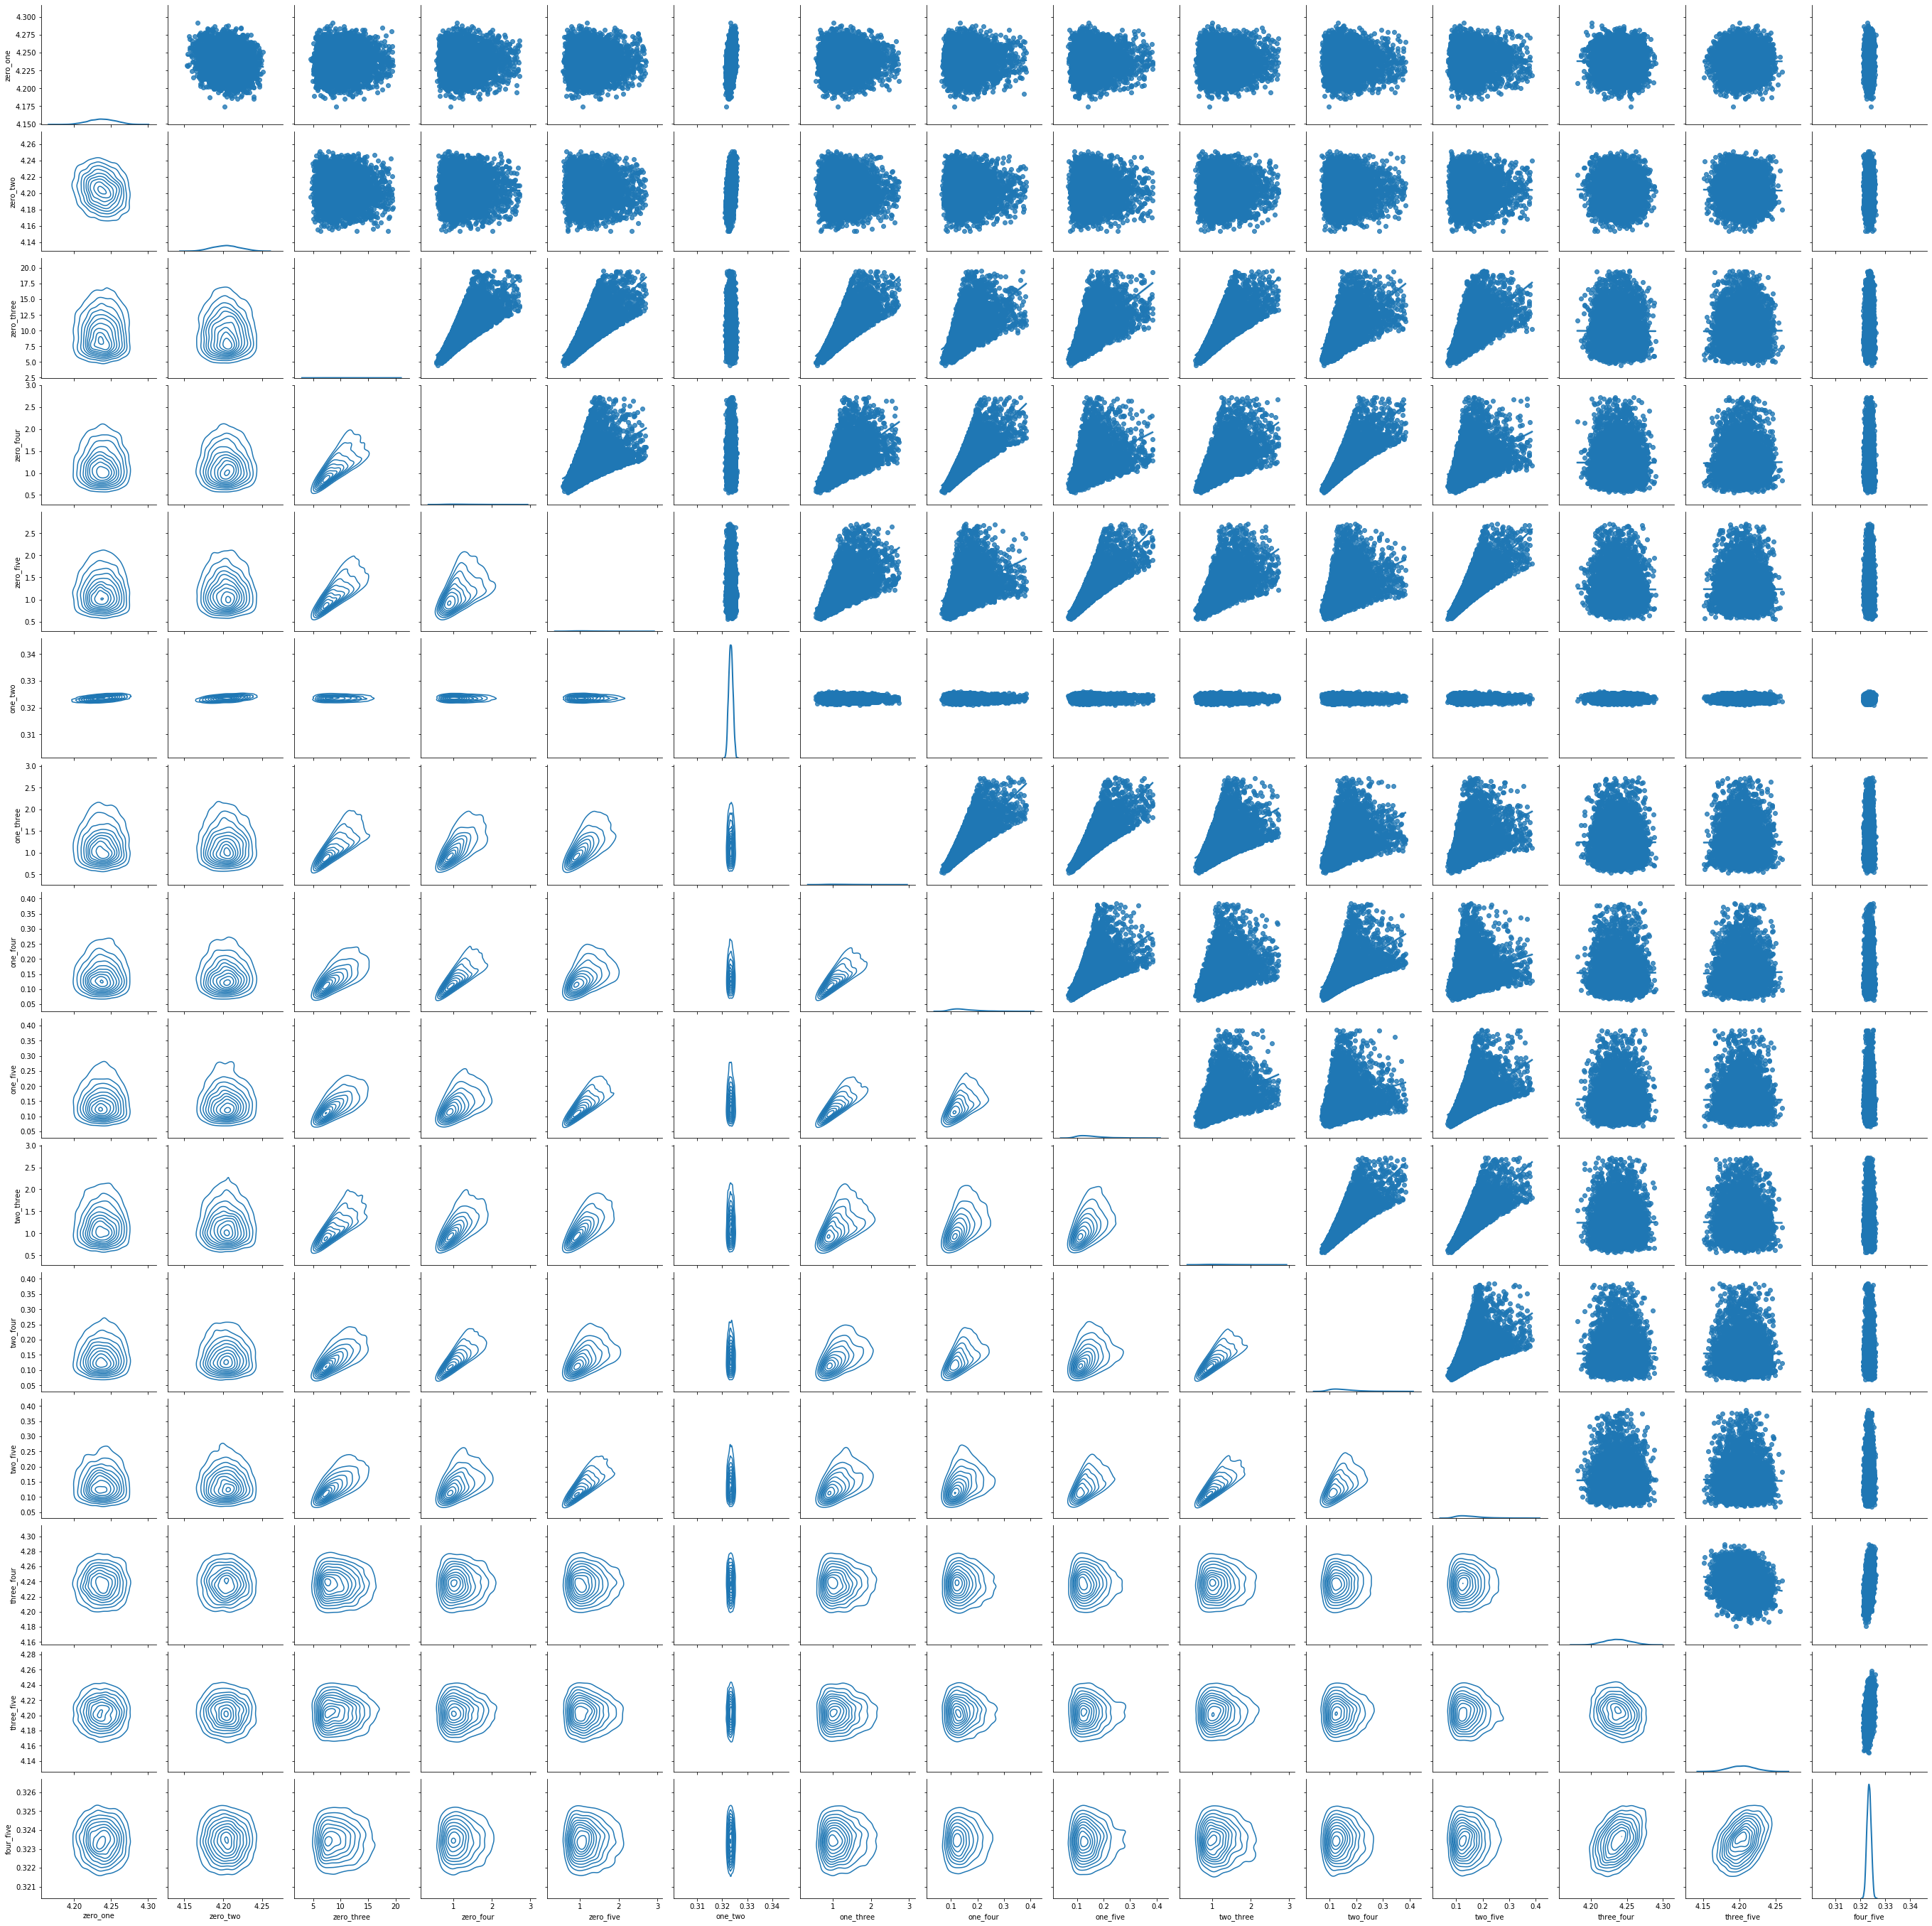

In [225]:
import pandas as pd
df = pd.DataFrame.from_records(off_diags)
dft=df.T
dft.columns = off_diags_names

g = sns.PairGrid(dft)
g = g.map_upper(sns.regplot)
g = g.map_lower(sns.kdeplot, colors="C0")
g = g.map_diag(sns.kdeplot, lw=2)

Reading structures from ./testing_model/featurization/columb_matrix_input/dimers.sdf.
Featurizing sample 0
TIMING: dataset construction took 0.004 s
Loading dataset from disk.
Reading structures from ./testing_model/featurization/columb_matrix_input/dimers.sdf.
Featurizing sample 0
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
Reading structures from ./testing_model/featurization/columb_matrix_input/dimers.sdf.
Featurizing sample 0
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
Reading structures from ./testing_model/featurization/columb_matrix_input/dimers.sdf.
Featurizing sample 0
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
Reading structures from ./testing_model/featurization/columb_matrix_input/dimers.sdf.
Featurizing sample 0
TIMING: dataset construction took 0.003 s
Loading dataset from disk.


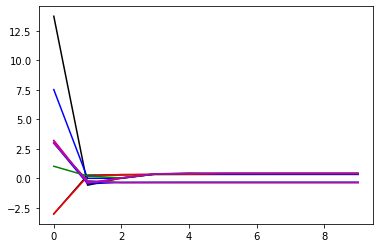

In [25]:
import numpy as np
import pandas as pd
import scipy

featurizers = dc.feat.CoulombMatrix(max_atoms=6)
input_file = './testing_model/featurization/columb_matrix_input/dimers.sdf' # really backed by water.sdf.csv
tasks = ["induction"]
featurizer = dc.data.SDFLoader(tasks, smiles_field="smiles", mol_field="mol",
                                   featurizer=featurizers, verbose=False)
dataset = featurizer.featurize(input_file)
move_mean=True
transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=dataset, move_mean=move_mean)
  ]
for transformer in transformers:
    dataset = transformer.transform(dataset)

fit_transformers = [dc.trans.CoulombFitTransformer(dataset)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

y_pred_test = model_i.predict(dataset)

plt.plot(y_pred_test,'k')
plt.plot(dataset.y,'-k')

featurizers = dc.feat.CoulombMatrix(max_atoms=6)
input_file = './testing_model/featurization/columb_matrix_input/dimers.sdf' # really backed by water.sdf.csv
tasks = ["electrostatics"]
featurizer = dc.data.SDFLoader(tasks, smiles_field="smiles", mol_field="mol",
                                   featurizer=featurizers, verbose=False)
dataset = featurizer.featurize(input_file)
move_mean=True
transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=dataset, move_mean=move_mean)
  ]
for transformer in transformers:
    dataset = transformer.transform(dataset)

fit_transformers = [dc.trans.CoulombFitTransformer(dataset)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

y_pred_test = model_el.predict(dataset)

plt.plot(y_pred_test,'r')
plt.plot(dataset.y,'-r')

featurizers = dc.feat.CoulombMatrix(max_atoms=6)
input_file = './testing_model/featurization/columb_matrix_input/dimers.sdf' # really backed by water.sdf.csv
tasks = ["dispersion"]
featurizer = dc.data.SDFLoader(tasks, smiles_field="smiles", mol_field="mol",
                                   featurizer=featurizers, verbose=False)
dataset = featurizer.featurize(input_file)
move_mean=True
transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=dataset, move_mean=move_mean)
  ]
for transformer in transformers:
    dataset = transformer.transform(dataset)

fit_transformers = [dc.trans.CoulombFitTransformer(dataset)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

y_pred_test = model_d.predict(dataset)

plt.plot(y_pred_test,'b')
plt.plot(dataset.y,'-b')

featurizers = dc.feat.CoulombMatrix(max_atoms=6)
input_file = './testing_model/featurization/columb_matrix_input/dimers.sdf' # really backed by water.sdf.csv
tasks = ["exchange"]
featurizer = dc.data.SDFLoader(tasks, smiles_field="smiles", mol_field="mol",
                                   featurizer=featurizers, verbose=False)
dataset = featurizer.featurize(input_file)
move_mean=True
transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=dataset, move_mean=move_mean)
  ]
for transformer in transformers:
    dataset = transformer.transform(dataset)

fit_transformers = [dc.trans.CoulombFitTransformer(dataset)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

y_pred_test = model_ex.predict(dataset)

plt.plot(y_pred_test,'g')
plt.plot(dataset.y,'-g')

featurizers = dc.feat.CoulombMatrix(max_atoms=6)
input_file = './testing_model/featurization/columb_matrix_input/dimers.sdf' # really backed by water.sdf.csv
tasks = ["total"]
featurizer = dc.data.SDFLoader(tasks, smiles_field="smiles", mol_field="mol",
                                   featurizer=featurizers, verbose=False)
dataset = featurizer.featurize(input_file)
move_mean=True
transformers = [
      deepchem.trans.NormalizationTransformer(
          transform_y=True, dataset=dataset, move_mean=move_mean)
  ]
for transformer in transformers:
    dataset = transformer.transform(dataset)

fit_transformers = [dc.trans.CoulombFitTransformer(dataset)]
regression_metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

y_pred_test = model_tot.predict(dataset)

plt.plot(y_pred_test,'m')
plt.plot(dataset.y,'-m')

#

dist_data = pd.read_table('distances.dat',delim_whitespace=True,header=None)
dist_data = dist_data.T
dist_data.columns = ['distance A']

#ax[0].hist(dist_data['distance A'],bins=50,color='#663333')

#plt.set_xlabel('Oxygen Distance (A)',fontsize=15)
#plt.set_yticks(())
#sigma = np.std(dist_data['distance A'])
#mu=np.mean(dist_data['distance A'])

#plt.hist(dist_data['distance A'], 50, density=1, histtype='step',lw = 2)
